# **Lecture 16 - Neural Networks** #

# CONTRIBUTORS #

This in-class exercise is to be done in pairs. Add the names of the two students in this text block.


# Workflow for today

I've copied and pasted the completed least squares fit from Lecture 13. Today we will repeat the same exercise, but use neural networks to fit data instead of using polynomials.

# Building up a few datasets #

We will define functions to generate a few datasets that we'll use throughout today's exercise.

**Noisy linear function.** 
Build up a function that samples N random points on the unit interval. Evaluate the function
$$y(x) = 2 x + \epsilon$$
where $\epsilon$ is sampled from a normal distribution with zero mean and standard deviation 0.2. You will find the functions `np.random.rand` and `np.random.normal` to be useful. The function should return a set of N pairs of x,y values.

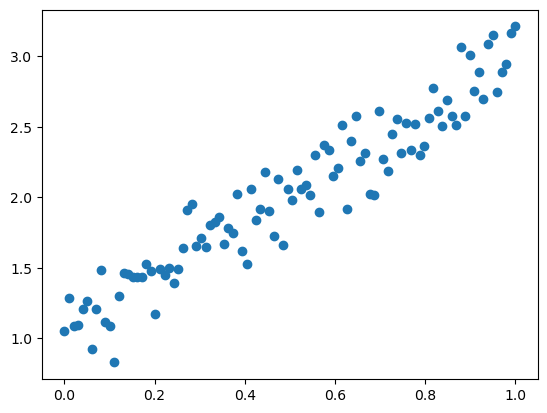

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def generate_noisylinear_data(N):
    x = np.linspace(0,1,N)
    y = 2*x + 1 + np.random.normal(0,0.2,N)
    # modify function here
    return  x,y

# Test the function
[xdata,ydata] = generate_noisylinear_data(100)
plt.plot(xdata,ydata,'o')

**Polynomial function.** Generate N points uniformly spaced on the unit interval (Hint: you should use `np.linspace`) and evaluate the cubic polynomial:
$$y(x) = x^3 - 2*x^2 + x - 4$$

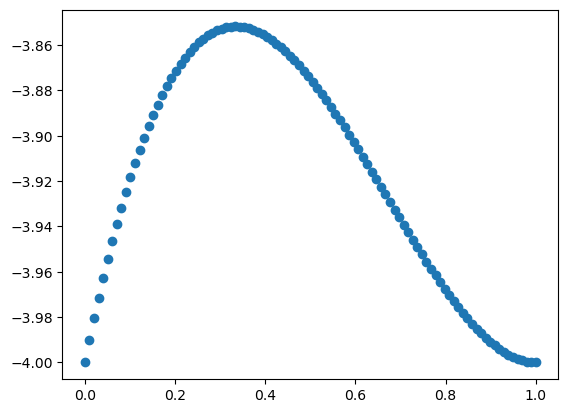

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def generate_polynomial_data(N):
    x = np.linspace(0,1,N)
    y = x**3 - 2*x**2+x-4.0
    # modify function here
    return  x,y

# Test the function
[xdata,ydata] = generate_polynomial_data(100)
plt.plot(xdata,ydata,'o')

**Continuous function.** Generate N points uniformly spaced on the unit interval, and evaluate the function:
$$y(x) = \sin 2 \pi x$$

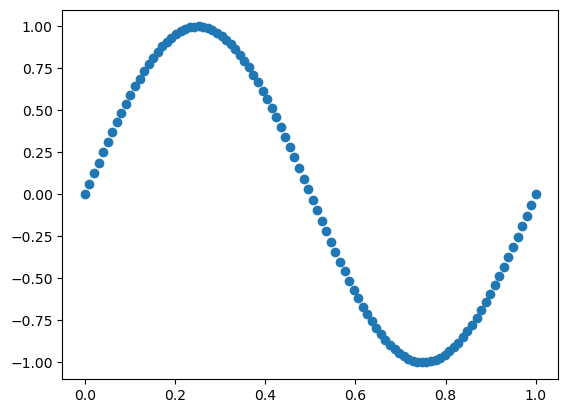

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def generate_smoothfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.sin(2.*np.pi*x)
    # modify function here
    return  x,y

# Test the function
[xdata,ydata] = generate_smoothfunction_data(100)
plt.plot(xdata,ydata,'o')

**Discontinuous function.** Generate N points uniformly spaced on the unit interval, and have them evaluate the function:
$$ y(x) =
\begin{cases} 
0 & \text{if } x < \frac12 \\
1 & \text{if } x \geq \frac12 
\end{cases}
$$

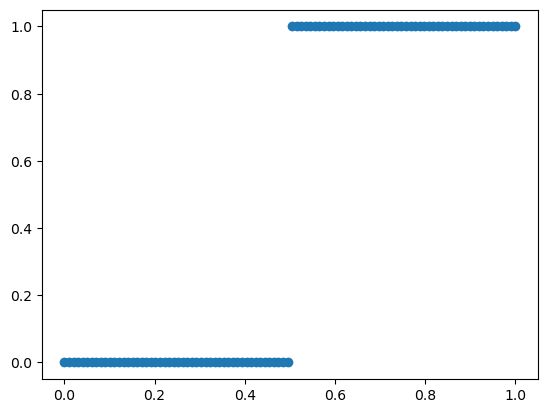

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def generate_stepfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.float32(x>0.5)
    # modify function here
    return  x,y

# Test the function
[xdata,ydata] = generate_stepfunction_data(100)
plt.plot(xdata,ydata,'o')

# Fit polynomials to data #

Building up a least squares solver is relatively straightforward, although the math is a little annoying. I'm going to step you through how to build up a class which will fit a polynomial to a given dataset. A skeleton for a `polyFitter` class is given below 

In [21]:
degree = 5
Npoints = 30
x = np.linspace(0, 1, Npoints)
functionList = [generate_noisylinear_data(Npoints)[1], generate_polynomial_data(Npoints)[1], generate_smoothfunction_data(Npoints)[1], generate_stepfunction_data(Npoints)[1]]
coefficients = []
for y in functionList:
    # Create the Vandermonde matrix
    A = np.vander(x, degree + 1)
    # Solve the least squares problem
    coeff, residuals, rank, s = np.linalg.lstsq(A, y, rcond=1e-15)
    coefficients.append(coeff)

# Print the polynomial coefficients
for i, coeff in enumerate(coefficients):
    print(f"Polynomial coefficients for function {i+1}: {coeff}")

# Evaluate the polynomial fit
fitList = []
for coeff in coefficients:
    fit = np.polyval(coeff, x)
    fitList.append(fit)

Polynomial coefficients for function 1: [ 23.73382826 -59.03491327  53.02616745 -21.04122687   5.62618607
   0.80069906]
Polynomial coefficients for function 2: [ 1.59369297e-13 -4.75175455e-13  1.00000000e+00 -2.00000000e+00
  1.00000000e+00 -4.00000000e+00]
Polynomial coefficients for function 3: [-5.40895419e+01  1.35223855e+02 -9.69776392e+01  1.02426041e+01
  5.58606684e+00  7.32771557e-03]
Polynomial coefficients for function 4: [ 7.60517204e+01 -1.90129301e+02  1.59705051e+02 -4.94282747e+01
  4.95329749e+00 -7.62463343e-02]


# Experiments! #

I've visualized for a polynomial fit here.

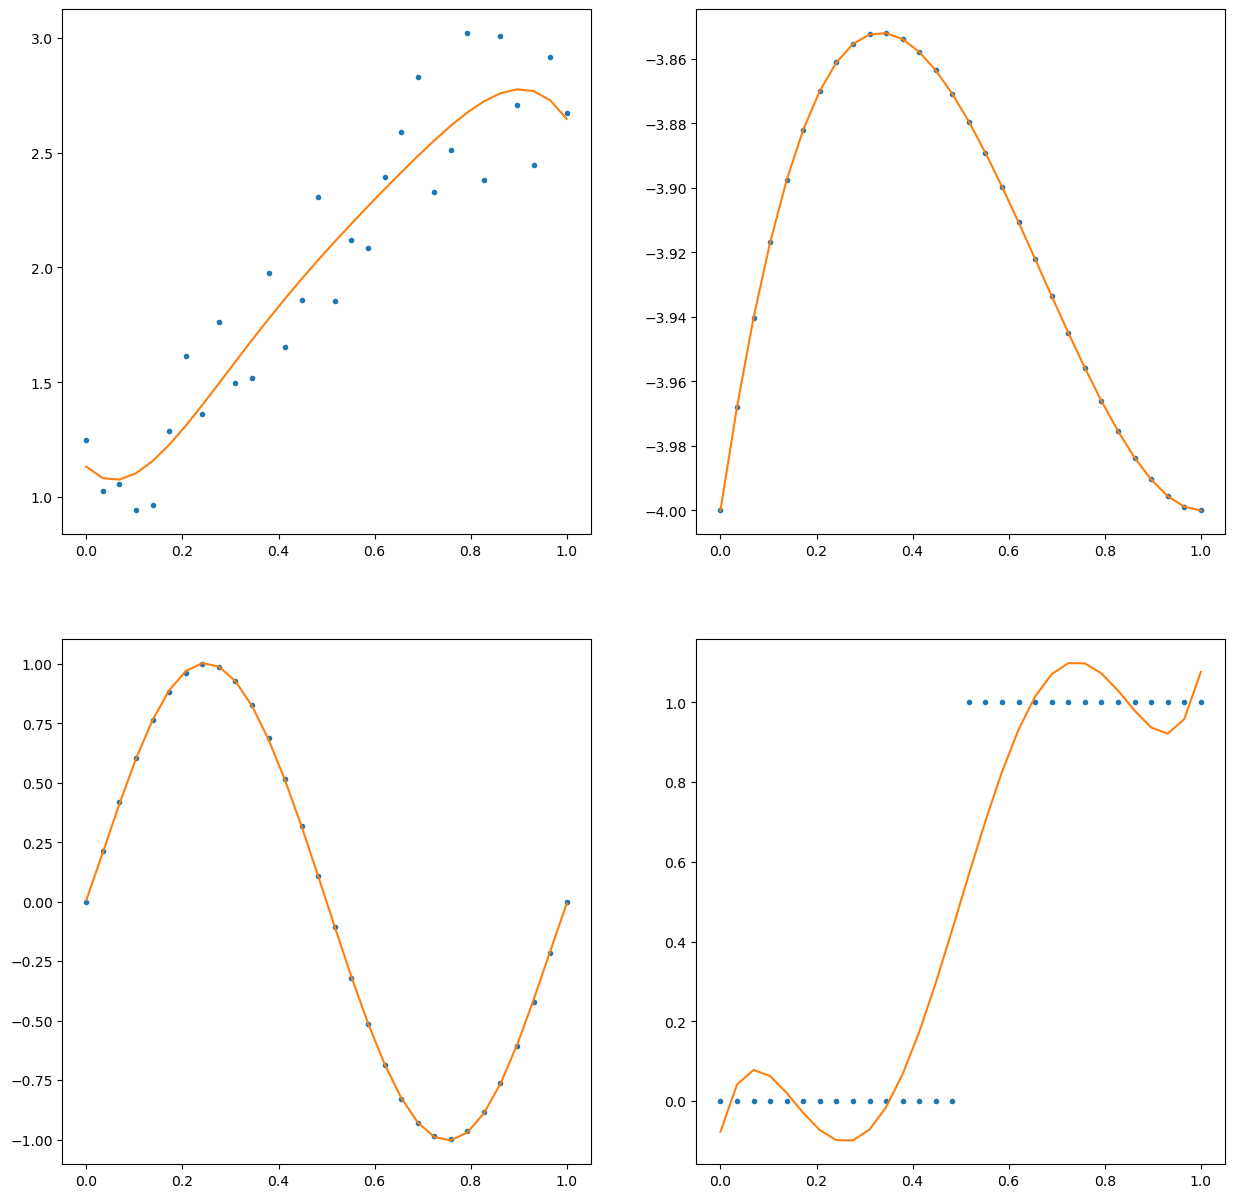

In [18]:
#this will plot a 3x3 grid of y = sin(2*pi*(n+m)x), where the row is n and the column is m
list_of_functions1 = [np.sin(2.*(0+m)*x) for m in range(3)]
list_of_functions2 = [np.sin(2.*(1+m)*x) for m in range(3)]
list_of_functions3 = [np.sin(2.*(2+m)*x) for m in range(3)]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes[0,0].plot(x,functionList[0],'.')
axes[0,1].plot(x,functionList[1],'.')
axes[1,0].plot(x,functionList[2],'.')
axes[1,1].plot(x,functionList[3],'.')
axes[0,0].plot(x,fitList[0])
axes[0,1].plot(x,fitList[1])
axes[1,0].plot(x,fitList[2])
axes[1,1].plot(x,fitList[3])

# Repeat the exercise with neural networks instead #

Now that we've gotten practice building pytorch models, we can have our first experience training a neural network. We will work with something called a *multilayer perceptron*, or MLP for short. An MLP is the most basic neural network, and was developed by Frank Rosenblatt in the 50s as a (not very good) model for how neurons in the brain work. As machine learning has evolved, people stopped interpreting these models as an artificial brain, and have recognized that they're just good nonlinear functions for fitting data.

An MLP consists of a hidden layer
$$h(x) = \sigma ( \mathbf{W} x + \mathbf{b})$$
followed by a linear layer
$$l(x) = \mathbf{C} x.$$
Both are combined to make a prediction
$$NN(x) = l(h(x))$$
Here, $\mathbf{W}$ and $\mathbf{b}$ are *weights* and *biases*. $\sigma$ is a *nonlinear activation function*. Originally, the activation function was meant to model neurons firing, but we realized that any nonlinear function can give interesting approximation properties.

In the code below, I show how to implement an MLP, and fit it to data. For your in class exercise today:
* Fit each of the four functions from above
* Play with the parameters - how does it behave for different numbers of neurons or learning rates?
* Generate a 2x2 grid of plots and paste at the bottom when you turn this in.

Epoch [1000/5000], Loss: 0.0315
Epoch [2000/5000], Loss: 0.0310
Epoch [3000/5000], Loss: 0.0308
Epoch [4000/5000], Loss: 0.0307
Epoch [5000/5000], Loss: 0.0306


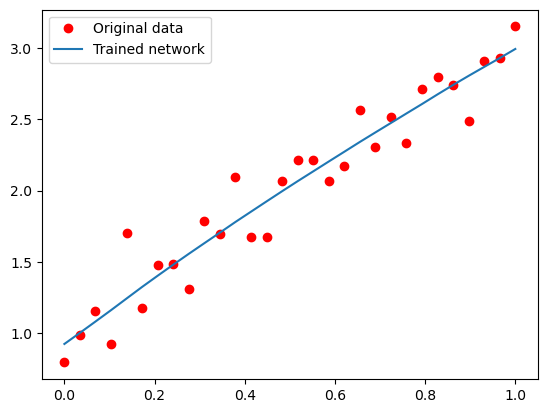

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model (in our case, its y = A*x + b)
class NeuralNetworkLayer(nn.Module):
    def __init__(self):
        super(NeuralNetworkLayer, self).__init__()
        # Define a simple MLP with one hidden layer
        self.Nneurons = 1000
        self.hidden = nn.Linear(1, self.Nneurons)  # 1 input feature, 10 hidden units
        self.output = nn.Linear(self.Nneurons, 1)  # 10 hidden units, 1 output feature


    def forward(self, x):
        # We use the ReLU activation function for the hidden layer
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

#Put our data into a tensor
x_data = torch.tensor(x.reshape(-1,1),dtype=torch.float32)
y_data = torch.tensor(functionList[0].reshape(-1,1),dtype=torch.float32)

# Instantiate the custom layer
layer = NeuralNetworkLayer()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(layer.parameters(), lr=0.001)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    outputs = layer(x_data)
    loss = criterion(outputs, y_data)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
# Plot the results
plt.plot(x, y_data, 'ro', label='Original data')
plt.plot(x, layer(x_data).detach().numpy(), label='Trained network')
plt.legend()
plt.show()



# Turning in assignments on Canvas #
In order to submit your assignment as a pair, you need to create a group on Canvas. This will enable you to both receive the same grade for one submission.

On Canvas, navigate to People > Groups > In-Class 16.
Find an empty group and add the names of both members of the pair.

Submit your work as both an ipynb and a pdf to Canvas.

Save the ipynb and upload from your hard drive. Also print a pdf file to ensure the graders can see you have completed the exercise, even if there are issues with the formatting in your jupyter notebook.

The student who did not submit should make sure that the group was created successfully by checking that they can also access the files on their Canvas page.